Lambda School Data Science

*Unit 4, Sprint 1, Module 2*

---

# Vector Representations (Prepare)


As we learned yesterday, machines cannot intrepret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for maching learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a dataframe and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the datascience team at the BBC. We want to recommend articles to visiters to on the BBC website based on the article they just read. Our team wants 

**Dataset:**

[D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.](http://mlg.ucd.ie/datasets/bbc.html)
*Please note that the dataset has been sampled down to tech articles only.* 

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

# Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). Each column represents a word. Each row represents a document. The value in each cell can be range of different things. The most traditional: counts of appearences of words, does the word appear at all (binary), and term-frequency inverse-document frequence (TF-IDF). 

**Discussion:** Don't we loose all the context and grammer if we do this? So Why does it work?

## Follow Along

In [76]:
""" Import Statements """

# Classics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_sm")

**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

In [77]:
text = "We created a new dataset which emphasizes diversity of content, by scraping content from the Internet. In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma. This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."

In [78]:
doc = nlp(text)

print([token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)])

['create', 'new', 'dataset', 'emphasize', 'diversity', 'content', 'scrape', 'content', 'internet', 'order', 'preserve', 'document', 'quality', 'page', 'curate', 'filter', 'human', 'specifically', 'outbound', 'link', 'Reddit', 'receive', '3', 'karma', 'think', 'heuristic', 'indicator', 'user', 'find', 'link', 'interesting', 'educational', 'funny', 'lead', 'high', 'datum', 'quality', 'similar', 'dataset', 'CommonCrawl']


In [79]:
list(doc.noun_chunks)

[We,
 a new dataset,
 diversity,
 content,
 content,
 the Internet,
 order,
 document quality,
 we,
 only pages,
 humans,
 we,
 outbound links,
 Reddit,
 at least 3 karma,
 a heuristic indicator,
 other users,
 the link,
 higher data quality,
 other similar datasets,
 CommonCrawl]

In [80]:
import os 
def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    
    data = []
    
    files = os.listdir(filefolder)
    
    for article in files: 
        
        path = os.path.join(filefolder, article)
                    
        if  path[-3:] == 'txt':
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [81]:
data = gather_data('./data')

In [82]:
data

[b'Ink helps drive democracy in Asia\r\n\r\nThe Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country\'s elections as part of a drive to prevent multiple voting.\r\n\r\nThis new technology is causing both worries and guarded optimism among different sectors of the population. In an effort to live up to its reputation in the 1990s as "an island of democracy", the Kyrgyz President, Askar Akaev, pushed through the law requiring the use of ink during the upcoming Parliamentary and Presidential elections. The US government agreed to fund all expenses associated with this decision.\r\n\r\nThe Kyrgyz Republic is seen by many experts as backsliding from the high point it reached in the mid-1990s with a hastily pushed through referendum in 2003, reducing the legislative branch to one chamber with 75 deputies. The use of ink is only one part of a general effort to show commitment towards more open elections - the 

### CountVectorizer

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
text = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet."," In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma."," This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
vect = CountVectorizer()

# tokenize and build vocab
vect.fit(text)

# transform text
dtm = vect.transform(text)

# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.

# The vocabulary dictionary does not represent the counts of words!!


In [84]:
print(vect.get_feature_names())

['as', 'at', 'be', 'been', 'by', 'can', 'commoncrawl', 'content', 'created', 'curated', 'data', 'dataset', 'datasets', 'diversity', 'document', 'educational', 'emphasizes', 'filtered', 'for', 'found', 'from', 'funny', 'have', 'heuristic', 'higher', 'humans', 'in', 'indicator', 'interesting', 'internet', 'karma', 'leading', 'least', 'link', 'links', 'new', 'of', 'only', 'or', 'order', 'other', 'outbound', 'pages', 'preserve', 'quality', 'received', 'reddit', 'scraping', 'similar', 'specifically', 'such', 'than', 'the', 'this', 'thought', 'to', 'used', 'users', 'we', 'whether', 'which']


In [87]:
print(dtm)

  (0, 4)	1
  (0, 7)	2
  (0, 8)	1
  (0, 11)	1
  (0, 13)	1
  (0, 16)	1
  (0, 20)	1
  (0, 29)	1
  (0, 35)	1
  (0, 36)	1
  (0, 47)	1
  (0, 52)	1
  (0, 58)	1
  (0, 60)	1
  (1, 1)	1
  (1, 3)	1
  (1, 4)	1
  (1, 9)	1
  (1, 14)	1
  (1, 17)	1
  (1, 20)	1
  (1, 22)	1
  (1, 25)	1
  (1, 26)	1
  (1, 30)	1
  :	:
  (2, 10)	1
  (2, 12)	1
  (2, 15)	1
  (2, 18)	1
  (2, 19)	1
  (2, 21)	1
  (2, 23)	1
  (2, 24)	1
  (2, 27)	1
  (2, 28)	1
  (2, 31)	1
  (2, 33)	1
  (2, 36)	1
  (2, 38)	1
  (2, 40)	2
  (2, 44)	1
  (2, 48)	1
  (2, 50)	1
  (2, 51)	1
  (2, 52)	1
  (2, 53)	1
  (2, 54)	1
  (2, 55)	1
  (2, 57)	1
  (2, 59)	2


In [88]:
# Dealing with Sparse Matrix
dtm.todense()

matrix([[0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2],
        [2, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
         1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0,
         0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0]],
       dtype=int64)

In [15]:
# Get Word Counts for each document
pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

,as,at,be,been,by,can,commoncrawl,content,created,curated,...,than,the,this,thought,to,used,users,we,whether,which
0,0,0,0,0,1,0,0,2,1,0,...,0,1,0,0,0,0,0,1,0,1
1,0,1,0,1,1,0,0,0,0,1,...,0,0,0,0,1,2,0,2,0,2
2,2,0,1,0,0,1,1,0,0,0,...,1,1,1,1,1,0,1,0,2,0


In [23]:
data[0]

b'Ink helps drive democracy in Asia\r\n\r\nThe Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country\'s elections as part of a drive to prevent multiple voting.\r\n\r\nThis new technology is causing both worries and guarded optimism among different sectors of the population. In an effort to live up to its reputation in the 1990s as "an island of democracy", the Kyrgyz President, Askar Akaev, pushed through the law requiring the use of ink during the upcoming Parliamentary and Presidential elections. The US government agreed to fund all expenses associated with this decision.\r\n\r\nThe Kyrgyz Republic is seen by many experts as backsliding from the high point it reached in the mid-1990s with a hastily pushed through referendum in 2003, reducing the legislative branch to one chamber with 75 deputies. The use of ink is only one part of a general effort to show commitment towards more open elections - the G

**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [27]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
bbcvect = CountVectorizer(stop_words=nlp.Defaults.stop_words)

bbcvect.fit(data)
# BBC articles in `data` variable 

bbc = bbcvect.transform(data)
bbc = pd.DataFrame(bbc.todense(), columns=bbcvect.get_feature_names())

In [29]:
bbc.head()

,00,000,000s,0051,007,01,028,04m,05,0530,...,zip,zodiac,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\Cooper\Anaconda3\envs\Mike\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


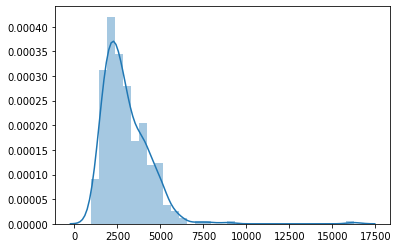

In [30]:
doc_len = [len(doc) for doc in data]
import seaborn as sns

sns.distplot(doc_len)

### TfidfVectorizer

## Term Frequency - Inverse Document Frequency (TF-IDF)

<center><img src="https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336" width="300"></center>

Term Frequency: Percentage of words in document for each word

Document Frequency: A penalty for the word existing in a high number of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents which will allow for each document's most different topics to rise to the top.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english')


# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
# View Feature Matrix as DataFrame
dtm.head()

,00,000,000s,0051,007,01,028,04m,05,0530,...,zip,zodiac,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zurich
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.020568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

# Tunning Parameters
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=tokenize, min_df=0.025, max_df=.05, ngram_range=(1,2))
dtm = tfidf.fit_transform(data)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,accord,apple,company,computer,game,high,net,new,say,sony,...,wish,work,world say,world service,worm,writer,xp,yahoo,year say,york
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.116897,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.140464,0.0,0.0,0.0,0.0,0.0,0.140464,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.180179,0.0,0.162664,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

# Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works? You may just think that search bars simply match your input text againist the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply n-dimensional distance to measure similarity, and query for input and output. 

## Follow Along

### Cosine Similarity (Brute Force)

In [35]:
# Calculate Distance of TF-IDF Vectors
from sklearn.metrics.pairwise import cosine_similarity

dist_matrix  = cosine_similarity(dtm)

In [36]:
# Turn it into a DataFrame
df = pd.DataFrame(dist_matrix)

In [37]:
# Our Similarity Matrix is ? size 
df.shape

(401, 401)

In [38]:
# Each row is the similarity of one document to all other documents (including itself)
df[0][:5]

0    1.000000
1    0.018413
2    0.000000
3    0.020277
4    0.026091
Name: 0, dtype: float64

In [42]:
# Grab the row
df[2].sort_values(ascending=False)[:10]

35     1.000000
2      1.000000
249    0.770115
95     0.748477
376    0.748477
291    0.742801
176    0.742801
315    0.433564
76     0.399825
226    0.270253
Name: 2, dtype: float64

In [43]:
print(data[2][:150])

b"Microsoft seeking spyware trojan\r\n\r\nMicrosoft is investigating a trojan program that attempts to switch off the firm's anti-spyware software.\r\n\r\nThe s"


In [44]:
print(data[249][:180])

b'Microsoft sets sights on spyware\r\n\r\nWindows users could soon be paying Microsoft to keep PCs free of spyware.\r\n\r\nFollowing the takeover of anti-spyware firm Giant, Microsoft said i'


### NearestNeighbor (K-NN) 

To address the computational inefficiencies of the brute-force approach, a variety of tree-based data structures have been invented. In general, these structures attempt to reduce the required number of distance calculations by efficiently encoding aggregate distance information for the sample. The basic idea is that if point  is very distant from point , and point  is very close to point , then we know that points  and  are very distant, without having to explicitly calculate their distance. In this way, the computational cost of a nearest neighbors search can be reduced to  or better. This is a significant improvement over brute-force for large data.

To address the inefficiencies of KD Trees in higher dimensions, the ball tree data structure was developed. Where KD trees partition data along Cartesian axes, ball trees partition data in a series of nesting hyper-spheres. This makes tree construction more costly than that of the KD tree, but results in a data structure which can be very efficient on highly structured data, even in very high dimensions.

A ball tree recursively divides the data into nodes defined by a centroid  and radius , such that each point in the node lies within the hyper-sphere defined by  and . The number of candidate points for a neighbor search is reduced through use of the triangle inequality:

With this setup, a single distance calculation between a test point and the centroid is sufficient to determine a lower and upper bound on the distance to all points within the node. Because of the spherical geometry of the ball tree nodes, it can out-perform a KD-tree in high dimensions, though the actual performance is highly dependent on the structure of the training data. In scikit-learn, ball-tree-based neighbors searches are specified using the keyword algorithm = 'ball_tree', and are computed using the class sklearn.neighbors.BallTree. Alternatively, the user can work with the BallTree class directly.

In [45]:
dtm.head()

,accord,apple,company,computer,game,high,net,new,say,sony,...,wish,work,world say,world service,worm,writer,xp,yahoo,year say,york
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.116897,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.140464,0.0,0.0,0.0,0.0,0.0,0.140464,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.180179,0.0,0.162664,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Instantiate
from sklearn.neighbors import NearestNeighbors

# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [50]:
# Query Using kneighbors 
nn.kneighbors([dtm.iloc[249]])

(array([[0.        , 0.58370317, 0.58370317, 0.66208998, 0.66208998]]),
 array([[249, 176, 291,  95, 376]], dtype=int64))

In [54]:
data[176][:200]

b'Microsoft debuts security tools\r\n\r\nMicrosoft is releasing tools that clean up PCs harbouring viruses and spyware.\r\n\r\nThe virus-fighting program will be updated monthly and is a precursor to Microsoft '

In [53]:
data[249][:200]

b'Microsoft sets sights on spyware\r\n\r\nWindows users could soon be paying Microsoft to keep PCs free of spyware.\r\n\r\nFollowing the takeover of anti-spyware firm Giant, Microsoft said it would soon release'

In [55]:
medium_random_ass_tech = [ """1. The VR and AI Enhancement
The list of trends in VR can never be complete without Artificial Intelligence. The duo has the potential to change the world. The two are in their infancy, to begin with, but they have made some appearances.

Take the example of Instagram and Snapchat. The dog faces and other funny filters are a creation of AI and VR. If you are looking for a scientific example, the Machine Learning Microscope of Google is a perfect example. This tool is capable of highlighting cancerous tissues. Now we are just waiting for AR and VR to create something powerful.

2. Consumer Entertainment
Oculus has partnered with the NBA. The brand is using VR to provide state of the art entertainment to its users. Yes, you have guessed it right. While you are wearing the Oculus VR headsets sitting on the courtside, you will feel as if you are actually in the NBA game. Cool, right?

VR headset technology is becoming accessible than before. It’s not just limited to gamers. TV watchers can get entertainment as well.

3. Education and Training
Education and training are one of the most costly and dangerous exercises in the workplace. With VR technology, organizations can cut back on the costs and give their employees the best training without exposing them to risk.

Recently, Walmart has used 17,000 Oculus Go headsets for training its employees in the customer service department. Similarly, the U.S. Army has been using Microsoft HoloLens technology to offer soldiers real-time updates on their environment.

4. Travel and Tourism
Traveling through VR is a different kind of traveling. The immersive video allows you to experience your destinations before even packing your suitcase. With VR, you can have the “try it before buy it experience.”

If you think you will feel claustrophobic in the cruise stateroom, then why not test the waters? Maybe you will feel better in a suit. VR allows you to explore the cruise ship rooms as well as the rooms in a hotel prior to booking it.

Apart from checking your room, you can also have a street view, check the venues, and restaurants nearby. With this virtual tour, you can decide whether the destination you have picked for yourself is good or not.

That’s not all, with VR travel apps, you can even relive your vacation after returning home. Now that’s something you will cherish for sure.

What’s the Future of VR?
Experts say the future of VR is location-based. But wait, it has nothing to do with the GPS technology. Location-based means bringing the VR experience to users where they are regardless of their location. They will be introduced to technology without having to purchase it.

However, for that, customers need to be aware of the proactiveness of VR. They must have an interest in VR for home as well. It still has a long way to go.

Conclusion
Consumers in today’s time are looking for experience. VR has the ability to play a huge role in the future of learning and development. With virtual simulation, a user can have real life-like experience at a fraction of cost.

The future for Virtual Reality is still in progress. It’s pretty much like the Cox channel lineup for different channels. Not all popular channels are available in all areas. Some of the VR tech and apps are in use but a majority of them are still in progress."""]


In [58]:
# Query for Sim of Random doc to BBC
new = tfidf.transform(medium_random_ass_tech)
nn.kneighbors(new.todense())

(array([[1.16317294, 1.24819413, 1.25896296, 1.26302003, 1.27402749]]),
 array([[248, 142, 114, 400, 394]], dtype=int64))

In [59]:
# Inspect Most relevant result
data[248]

b'Gamer buys $26,500 virtual land\r\n\r\nA 22-year-old gamer has spent $26,500 (\xc2\xa313,700) on an island that exists only in a computer role-playing game (RPG).\r\n\r\nThe Australian gamer, known only by his gaming moniker Deathifier, bought the island in an online auction. The land exists within the game Project Entropia, an RPG which allows thousands of players to interact with each other. Entropia allows gamers to buy and sell virtual items using real cash, while fans of other titles often use auction site eBay to sell their virtual wares. Earlier this year economists calculated that these massively multi-player online role-playing games (MMORPGs) have a gross economic impact equivalent to the GDP of the African nation of Namibia.\r\n\r\n"This is a historic moment in gaming history, and this sale only goes to prove that massive multi-player online gaming has reached a new plateau," said Marco Behrmann, director of community relations at Mindark, the game\'s developer.\r\n\r\nThe

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>

## Overview
### BoW discards textual context

One of the limitations of Bag-of-Words approaches is that any information about the textual context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

### Word2Vec Intuition
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the Distribution Hypothesis (Reference: Distribution Hypothesis Theory  -https://en.wikipedia.org/wiki/Distributional_semantics. The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the raniest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "raniest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and raniest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have the same meaning because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

### Word2Vec Variants

#### Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

## Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Proshe”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

## Notable Differences between Word Embedding methods:

1) W2V focuses less document topic-modeling. You'll notice that the vectorizations don't really retain much information about the original document that the information came from. At least not in our examples.

2) W2V can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings (thank you Google) to do really cool things!

*^ All that noise....AND Spacy has pretrained a Word2Vec model you can just use? WTF JC?*

Let's take a look at how to do it. 

In [60]:
# Process a text
doc = nlp("Two bananas in pyjamas")

# Get the vector for the token "bananas"
bananas_vector = doc.vector
print(bananas_vector)

[ 1.0842137  -0.25981063 -2.8158834  -1.8915112   0.7477449   1.1429701
  1.1429548   2.7121956  -2.5027528   3.4488      0.9439746   1.3971639
 -1.5815352  -0.9335219  -0.13457859 -0.35799843 -1.0552816   0.5932776
  1.1505623   3.636026   -3.2593246   1.1050496   1.4861381   1.5954304
  0.55114055  1.7855846   2.3280182   1.219213    1.7298036   1.0685508
  1.8240969  -1.9124128  -2.1908686   0.3174642  -0.46433026 -0.24596563
 -1.2255001  -0.09551847 -2.1111736   1.0506496  -0.5380329   2.7754307
  1.2412694  -2.2468576   1.6791102  -0.27741486 -2.7495368  -1.454313
 -0.90234524 -1.2559149   0.03862846 -3.6402614  -0.01982132 -1.5564928
  0.45967612  0.44516432 -1.48547     2.2065082  -0.70703757 -0.6043764
 -0.0420624  -1.3105087   2.6387398  -1.806697   -0.81524813  3.082488
 -0.6467378   0.36735654 -0.15230903 -0.84734154  0.8902142  -1.4670311
  1.35256     0.9052353  -0.08156714 -0.08545418  0.24632841 -1.673816
 -0.82938045 -2.383117   -0.7628685  -1.1396155  -2.3347688   2.25

In [61]:
len(bananas_vector)

96

In [36]:
doc1 = nlp("It's a warm summer day")
doc2 = nlp("It's sunny outside")

# Get the similarity of doc1 and doc2
similarity = doc1.__
print(similarity)

0.8789265574516525


In [62]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['car', 'truck', 'suv', 'race', 'elves', 'dragon', 'sword', 'king', 'queen', 'prince', 'horse', 'fish' , 'lion', 'tiger', 'lynx', 'potato']

# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(get_word_vectors(words))

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(get_word_vectors(words))

# let's look at our new 2D word vectors
word_vecs_2d

array([[-4.57295443, -0.85527396],
       [-0.23769439,  6.12381127],
       [-4.86170961, -5.85960006],
       [-8.68406444, -1.80542046],
       [19.82496988, -6.63966869],
       [-2.70448199,  4.69209728],
       [-4.24058874,  3.3981086 ],
       [-3.12993239, -0.27887652],
       [ 1.24960866, -6.81772987],
       [-0.53048559, -3.15247678],
       [-0.59356044,  2.79535296],
       [ 1.09888324, -7.31997126],
       [ 2.89600411,  8.14885432],
       [ 7.71985579, 12.25193322],
       [-0.83765635, -1.03468061],
       [-2.3961933 , -3.64645945]])

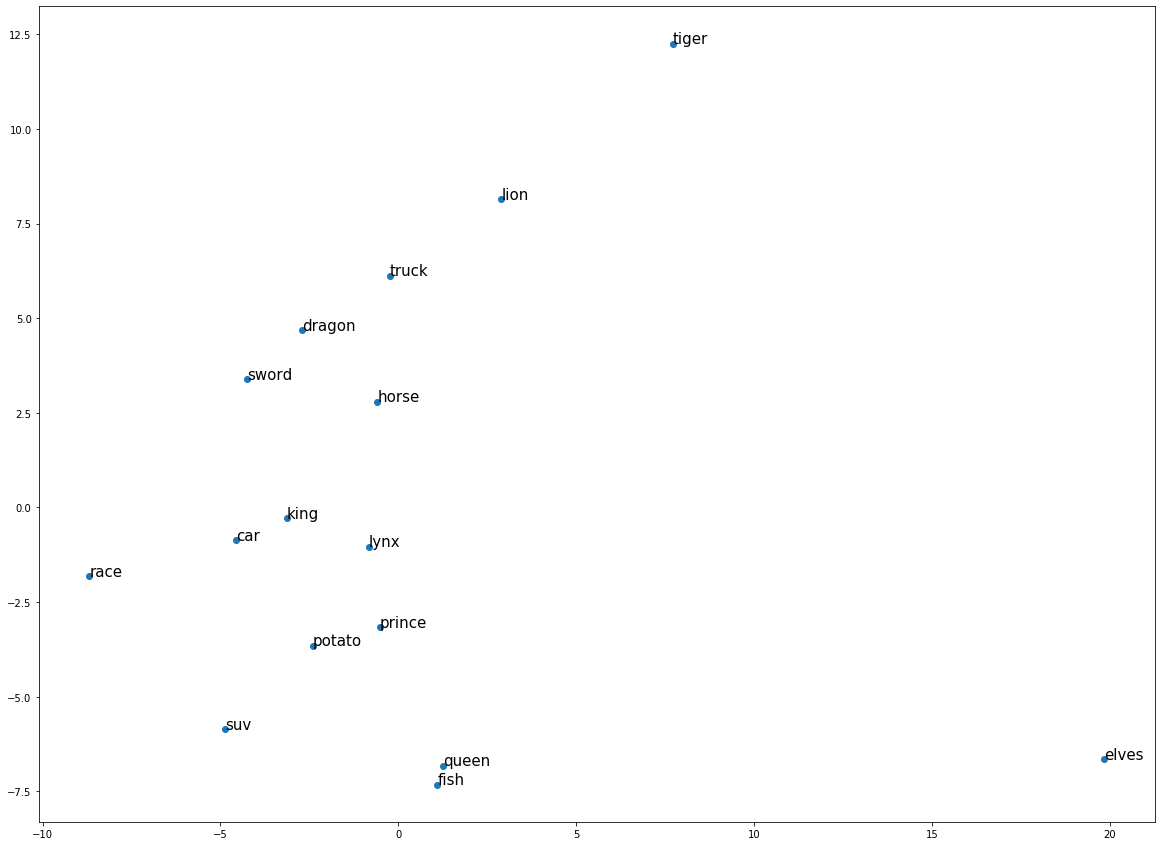

In [63]:
# create a nice big plot 
plt.figure(figsize=(20,15))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.show()

## Follow Along
### Extract Document Vectors

Let's see how much the quality of our query will work when we try a new embedding model.

Steps:
* Extract Vectors from Each Document
* Search using KNN


In [64]:
X = [nlp(str(d)).vector for d in data]

In [65]:
X

[array([ 0.09972619, -0.81740606, -1.5222907 , -1.2049595 , -0.29396677,
         0.8796237 ,  2.0533142 ,  0.6505719 , -0.47657323,  0.19492768,
         0.31016698,  0.6826426 , -1.4154865 , -0.7578385 , -0.55801076,
        -0.3384382 , -0.02697809,  0.82146496,  1.0291137 ,  1.4559088 ,
        -0.6065639 , -0.5876997 ,  1.0600804 ,  1.8108777 ,  0.17108524,
         1.0022931 ,  0.9898762 , -0.26217517,  0.5675411 ,  2.0336487 ,
         1.2188652 , -0.5539209 , -1.3258777 , -0.83354837,  1.4701072 ,
         0.67167735,  0.27384192,  0.79400104, -1.4921637 ,  1.2047421 ,
         0.05552397,  1.2463603 ,  1.1242561 ,  0.9071764 , -0.95829916,
        -0.6841659 , -0.69049376, -0.57442343, -0.7308679 , -0.84357005,
        -0.6223182 , -0.7222337 , -1.286478  ,  0.1293525 ,  0.00961932,
        -0.7924656 , -0.5236456 ,  0.750833  , -1.4833678 , -0.07076224,
        -0.35937545, -1.1904662 ,  0.5871489 , -0.05476955, -1.2318639 ,
         0.79464537, -0.1767827 , -0.04433632, -1.0

## Challenge

You will extract word embeddings from documents using Spacy's pretrained model in the upcoming module project. 

# Review
For your module project assignment you will create vector repsentations of indeed.com Data Science job listings. You will then estimate a similarity model to perform searches for job descriptions. Get started with your [module project here](./LS_DS_412_Vector_Representations_Assignment.ipynb)

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf